# 21 cm foreground removal: PCA cleaning
### In this version, we apply PCA to all the data cube and we bin afterwards.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PCA_functions as PCA
from astropy.io import fits
from tqdm import tqdm
import configparser
import scipy.ndimage as ndimage
import os

## Load the information contained in the configfile

In [2]:
config = configparser.ConfigParser()
config.read('../../../config/configfile_data_PCA.ini')

# Data parameters
fname_cube = config['data']['fname_cube'] # Path to the data cube
angle = float(config['data']['angle']) # angle that we want to clean in degrees (the maximum value is 8 degrees)

# Mask parameters
fname_mask = config['mask']['fname_mask'] # Path to the probability mask
threshold = float(config['mask']['threshold']) # Threshold used to consider a point source to be detected

# PCA parameters
ncomp = int(config['PCA']['ncomp']) # number of components used in the PCA
nfreq_bins_pca = int(config['PCA']['nfreq_bins_pca']) # number of equal size frequency bins

# Output parameters
nfreq_bins_out = int(config['output']['nfreq_bins_out']) # number of equal size frequency bins
output_dir = config['output']['output_dir'] # Output directory where the results are stored
std_gauss = float(config['output']['std_gauss']) # Standard deviation for Gaussian kernel

## Load the data cube

To limit noise, only the central 4x4 degrees out of the full 8x8 degrees FoV are meant to be used for the power spectrum computation.

In [3]:
# Spatial resolution of the cube in arcsecs
resolution = 16
# Minimum frequency of the experiment in MHz
min_freq = 106
# Maximum frequency of the experiment in MHz
max_freq = 196 
# Channel width in MHz
delta_freq = 0.1
# Number of pixels in the output image for the power spectrum computation
Npix_ps = angle*3600/resolution
# Get the shape of the data cube
data_shape = fits.open(fname_cube)[0].data.shape
# Number of pixels in the x-axis in the data 
Npix_data = data_shape[1] 
# Indeces corresponding to the central 4x4 degrees region
ind1 = int(Npix_data/2 - Npix_ps/2)
ind2 = int(Npix_data/2 + Npix_ps/2)
# Frequency array experiment
freq = np.arange(min_freq, max_freq + delta_freq, delta_freq)
# Header of the data cube
header = fits.open(fname_cube)[0].header
# Data of the cube
data = fits.open(fname_cube)[0].data[:, ind1:ind2, ind1:ind2]
# Frequency binning for the pca cleaning
if nfreq_bins_pca == 1:
    print('No binning for the PCA cleaning')
    data_ps = data
else:
    print(f"Binning in {nfreq_bins_pca} bins for PCA cleaning")
    data_ps = []
    freq_bins_pca = np.arange(0, data_shape[0], data_shape[0]//nfreq_bins_pca, dtype=int)
    # The last bin has one more slice than the rest
    freq_bins_pca[nfreq_bins_pca] += 1
    for i in tqdm(range(len(freq_bins_pca)-1)):
        data_ps.append(fits.open(fname_cube)[0].data[freq_bins_pca[i]:freq_bins_pca[i+1], ind1:ind2, ind1:ind2])

Binning in 6 bins for PCA cleaning


100%|██████████| 6/6 [00:00<00:00, 263.60it/s]


## Load the point sources mask

The point sources mask contains not binary values of 0 or 1, but the probabilities produced by the model's output. These probabilistic masks are processed based on a predetermined threshold. For example, if a threshold of 0.4 is set, pixels with probabilities above this value will be marked as '1', and the rest as '0'.

In [4]:
if False:
    # Load the mask and restrict it to the central part
    mask = fits.open(fname_mask)[0].data[:, ind1:ind2, ind1:ind2, 0]
    # Apply the threshold to the data
    mask_thresh = np.zeros_like(mask, dtype=int)
    mask_thresh[mask > threshold] = 1
    mask_one_slice = np.maximum.reduce(mask_thresh, axis=0)
    mask_one_slice_neg = np.zeros_like(mask_one_slice)
    mask_one_slice_neg[mask_one_slice == 0] = 1

We generate one foreground mask per frequency bin for pca and for the power spectrum binning. This is done by calculating the maximum of the pixels in the slices in the frequency interval of interest.

In [5]:
if False:
    # Frequency binning of the mask for the pca cleaning
    if nfreq_bins_pca == 1:
        print('No binning of the mask for the PCA cleaning')
        mask_binned_pca = np.maximum.reduce(mask_thresh, axis=0)
        mask_binned_pca_neg = np.zeros_like(mask_binned_pca)
        mask_binned_pca_neg[mask_binned_pca == 0] = 1
    else:
        print(f"Binning the mask in {nfreq_bins_pca} bins for PCA cleaning")
        mask_binned_pca = []
        mask_binned_pca_neg = []
        for i in tqdm(range(len(freq_bins_pca)-1)):
            # We create a common mask for all the slices.
            mask_binned_pca.append(np.maximum.reduce(mask_thresh[freq_bins_pca[i]:freq_bins_pca[i+1], :, :], axis=0))
            mask_binned_pca_neg.append(np.zeros_like(mask_binned_pca[i]))
            mask_binned_pca_neg[i][mask_binned_pca[i] == 0] = 1
    
    # Frequency binning of the mask for the output
    freq_bins_out = np.arange(0, data_shape[0], data_shape[0]//nfreq_bins_out, dtype=int)
    freq_bins_out[nfreq_bins_out] += 1 
    if nfreq_bins_out == 1:
        print('No binning of the mask for the output')
        mask_binned_out = np.maximum.reduce(mask_thresh, axis=0)
        mask_binned_out_neg = np.zeros_like(mask_binned_out)
        mask_binned_out_neg[mask_binned_out == 0] = 1
    else:
        print(f"Binning the mask in {nfreq_bins_out} bins for the output")
        mask_binned_out = []
        mask_binned_out_neg = []
        for i in tqdm(range(len(freq_bins_out)-1)):
            # We create a common mask for all the slices.
            mask_binned_out.append(np.maximum.reduce(mask_thresh[freq_bins_out[i]:freq_bins_out[i+1], :, :], axis=0))
            mask_binned_out_neg.append(np.zeros_like(mask_binned_out[i]))
            mask_binned_out_neg[i][mask_binned_out[i] == 0] = 1

Binning the mask in 6 bins for PCA cleaning


100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


Binning the mask in 6 bins for the output


100%|██████████| 6/6 [00:01<00:00,  5.62it/s]


## Run PCA method

    1) Run PCA on ncomp components, to get the following projection matrix.

$$d\rightarrow P = WW^T.$$

    2) Project the PCA solution back to the image space from the components space.

$$d^{PCA} = P\cdot d.$$

    3) Obtain the clean solution from substraction of the PCA result to the data.
$$d^{clean} = d-d^{PCA}.$$

I do not do PSF deconvolution in any of the data products.

In [6]:
if nfreq_bins_pca == 1:
    nsamples, nx, ny = data_ps.shape
    cube_2d = data_ps.reshape((nsamples,nx*ny))
    cube_2d, mean_cube_2d, eigvals, eigvecs = PCA.PCA_eig_decomposition(np.array(cube_2d))
    fg_amps, fg_field = PCA.PCA_solution(ncomp, eigvecs, cube_2d, mean_cube_2d)
    clean_field = data_ps - fg_field
else:   
    cube_2d = [None] * nfreq_bins_pca
    mean_cube_2d = [None] * nfreq_bins_pca
    eigvals = [None] * nfreq_bins_pca
    eigvecs = [None] * nfreq_bins_pca
    fg_amps = [None] * nfreq_bins_pca
    # Create a single array to store the 4 components PCA and the clean cube
    fg_field = np.zeros((data_shape[0], int(Npix_ps), int(Npix_ps)))
    clean_field = np.zeros((data_shape[0], int(Npix_ps), int(Npix_ps)))
    
    for i in tqdm(range(nfreq_bins_pca)):
        nsamples, nx, ny = data_ps[i].shape
        cube_2d[i] = data_ps[i].reshape((nsamples,nx*ny))
        cube_2d[i], mean_cube_2d[i], eigvals[i], eigvecs[i] = PCA.PCA_eig_decomposition(np.array(cube_2d[i]))
        fg_amps[i], fg_field[freq_bins_pca[i]:freq_bins_pca[i+1], :, :] = PCA.PCA_solution(ncomp, eigvecs[i], cube_2d[i], mean_cube_2d[i])
        clean_field[freq_bins_pca[i]:freq_bins_pca[i+1], :, :] = data_ps[i] - fg_field[freq_bins_pca[i]:freq_bins_pca[i+1], :, :]

100%|██████████| 6/6 [00:38<00:00,  6.41s/it]


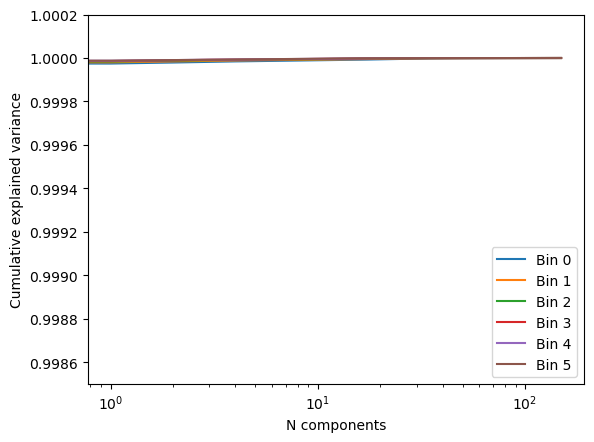

In [7]:
plt.figure()
if nfreq_bins_pca == 1:
    plt.plot(np.cumsum(eigvals)/np.sum(eigvals), label=f'Only one bin!')
else:
    for i in range(nfreq_bins_pca):
        plt.plot(np.cumsum(eigvals[i])/np.sum(eigvals[i]), label=f'Bin {i}')
plt.xlabel('N components')
plt.ylabel('Cumulative explained variance')
plt.semilogx()
plt.ylim([0.9985, 1.0002])
plt.legend(loc='lower right')
plt.show()

## Plot a set of slices to check the result of the PCA cleaning

Slices: [  0 150 300 450 600 750 900]


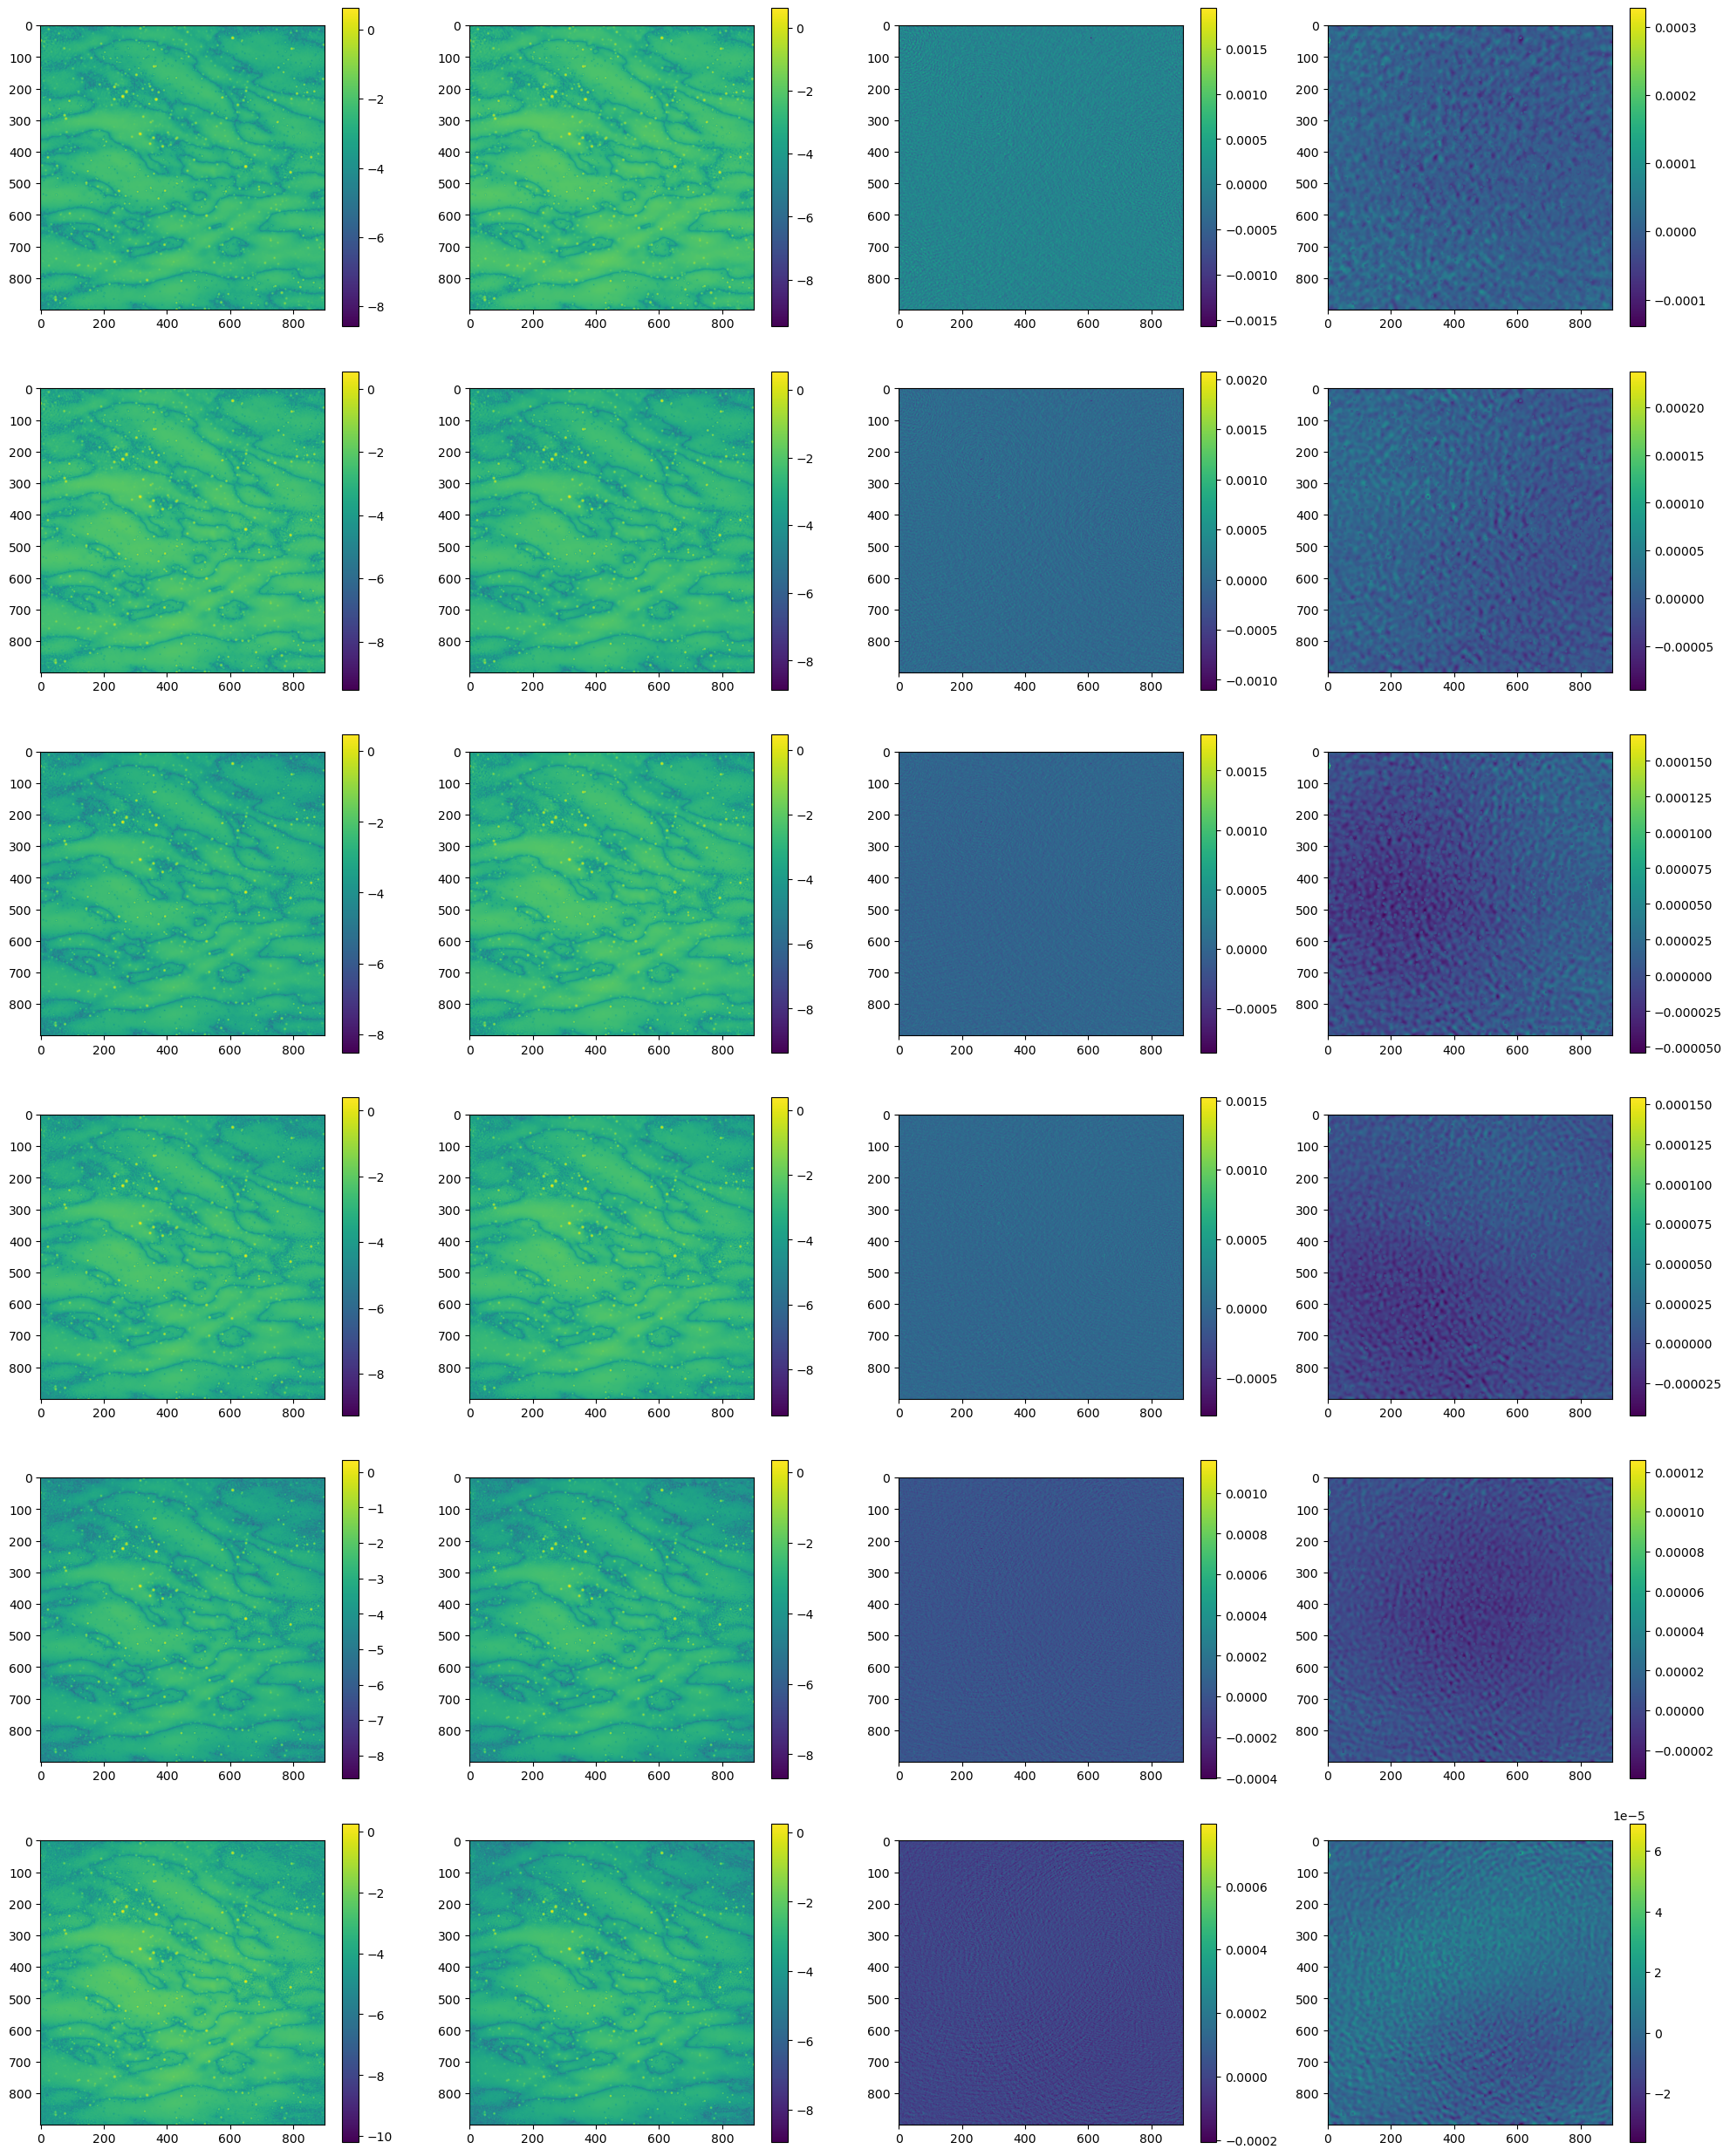

In [8]:
# Check if the output directory exist. If not it is created.
os.makedirs(output_dir, exist_ok=True)

slices = np.arange(0, data_shape[0], data_shape[0]//nfreq_bins_out, dtype=int)
print('Slices: ' + str(slices))
# Define the number of rows and columns
nrows = nfreq_bins_out
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,25))
# Iterate over rows
for i, slice in zip(range(nrows), slices):
    im0 = axes[i, 0].imshow(np.log10(np.abs(data[slice, :, :])))
    plt.colorbar(im0, ax=axes[i, 0], orientation='vertical')
    im1 = axes[i, 1].imshow(np.log10(np.abs(fg_field[slice, :, :])))
    plt.colorbar(im1, ax=axes[i, 1], orientation='vertical')
    im2 = axes[i, 2].imshow(clean_field[slice, :, :])
    plt.colorbar(im2, ax=axes[i, 2], orientation='vertical')
    mask_one_slice_neg = 1
    im3 = axes[i, 3].imshow(ndimage.gaussian_filter(clean_field[slice, :, :], sigma=std_gauss, order=0)*mask_one_slice_neg)
    plt.colorbar(im3, ax=axes[i, 3], orientation='vertical')
# Adjust layout
plt.tight_layout()
# Show the plot
plt.savefig(f"{output_dir}/plot_PCA_Clean.png")
# The units of the plots are Jy/beam.

## Bin the data products to prepare them for the power spectrum estimation 

In [9]:
clean_field_binned = [None] * nfreq_bins_out
clean_field_binned_smooth = [None] * nfreq_bins_out

freq_bins_out = np.arange(0, data_shape[0], data_shape[0]//nfreq_bins_out, dtype=int)
# The last bin has one more slice than the rest
freq_bins_out[nfreq_bins_out] += 1       
for bin in tqdm(range(nfreq_bins_out)):
    clean_field_binned[bin] = clean_field[freq_bins_out[bin]:freq_bins_out[bin+1], :, :]
    clean_field_binned_smooth[bin] = np.zeros_like(clean_field_binned[bin])
    for slice in range(clean_field_binned[bin].shape[0]):
        clean_field_binned_smooth[bin][slice, :, :] = ndimage.gaussian_filter(clean_field_binned[bin][slice, :, :], sigma=std_gauss, order=0)

100%|██████████| 6/6 [00:38<00:00,  6.33s/it]


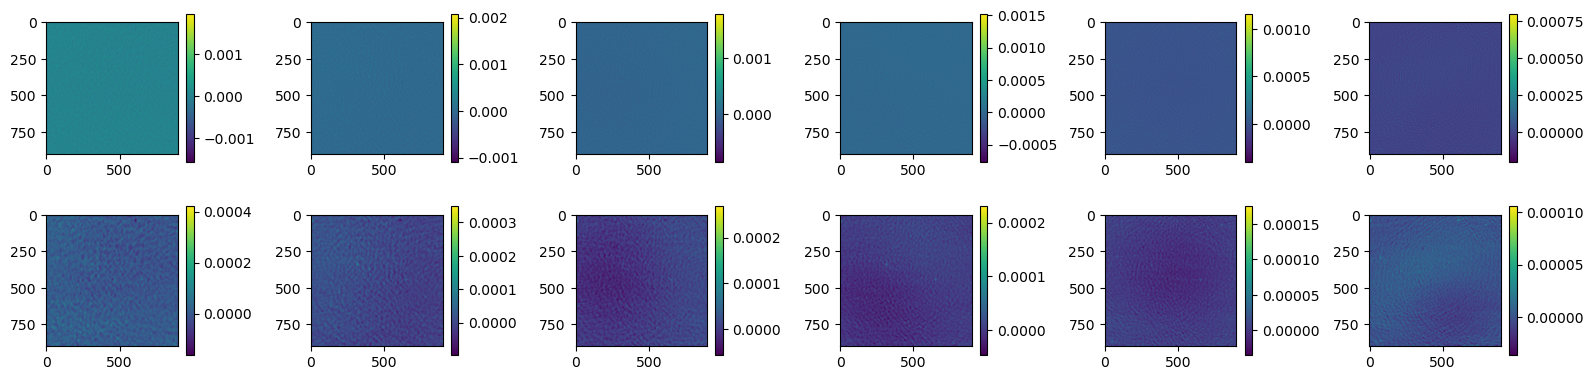

In [10]:
slice = 0
# Define the number of rows and columns
nrows = 2
ncols = nfreq_bins_out
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,4))
# Iterate over rows
for i in range(ncols):
    im0 = axes[0, i].imshow(clean_field_binned[i][slice, :, :])
    plt.colorbar(im0, ax=axes[0, i], orientation='vertical')
    im2 = axes[1, i].imshow(clean_field_binned_smooth[i][slice, :, :])
    plt.colorbar(im2, ax=axes[1, i], orientation='vertical')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Save the data products in fits files 

In [11]:
for bin in tqdm(range(nfreq_bins_out)):
    fname = f'{output_dir}/PCA_cleaned_{freq_bins_out[bin]}_{freq_bins_out[bin+1]}.fits'
    fname_smooth = f'{output_dir}/PCA_cleaned_smooth_{freq_bins_out[bin]}_{freq_bins_out[bin+1]}.fits'

    # Create a FITS header by modifying the one from the data fits file
    header['NAXIS1'] = clean_field_binned[bin].shape[2]
    header['NAXIS2'] = clean_field_binned[bin].shape[1]
    header['NAXIS3'] = clean_field_binned[bin].shape[0]
    header['CRVAL3'] = freq[freq_bins_out[bin]]*1e6 # in Hz
    # Create a FITS HDU (Header/Data Unit) containing the matrix
    hdu_clean = fits.PrimaryHDU(data=clean_field_binned[bin], header=header)
    hdu_clean_smooth = fits.PrimaryHDU(data=clean_field_binned_smooth[bin], header=header)
    # Create a HDU list and add the primary HDU to it
    hdul_clean = fits.HDUList([hdu_clean])
    hdul_clean_smooth = fits.HDUList([hdu_clean_smooth])
    
    # Write the HDU list to the FITS file
    hdul_clean.writeto(fname, overwrite=True)
    hdul_clean_smooth.writeto(fname_smooth, overwrite=True)

100%|██████████| 6/6 [00:15<00:00,  2.61s/it]
